In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
from conv_6_models import Real3, Real4, Quat

In [2]:
dataset = "cifar10"

device = torch.device('cuda:0')

data = pd.read_csv(f"../data/{dataset}/train.csv", header=None).to_numpy()
x, y = (data[:, 1:]/255).reshape(-1, 3, 32, 32).transpose((0, 3, 2, 1)), torch.nn.functional.one_hot(torch.Tensor(data[:, 0]).long(), 10).to(device)

test = pd.read_csv(f"../data/{dataset}/test.csv", header=None).to_numpy()
x_test, y_test = (test[:, 1:]/255).reshape(-1, 3, 32, 32).transpose((0, 3, 2, 1)), torch.nn.functional.one_hot(torch.Tensor(test[:, 0]).long(), 10).to(device)

In [3]:
mat = np.array(
    [
        [1, 0, 0, 0.299],
        [0, 1, 0, 0.587],
        [0, 0, 1, 0.144]
    ]
)  # RGB to RGB+Grayscale conversion matrix

x_4 = torch.Tensor(np.dot(x, mat).transpose((0, 3, 1, 2))).float().to(device)
x_test_4 = torch.Tensor(np.dot(x_test, mat).transpose((0, 3, 1, 2))).float().to(device)


x_3 = torch.Tensor(x.transpose(0, 3, 1, 2)).float().to(device)
x_test_3 = torch.Tensor(x_test.transpose(0, 3, 1, 2)).float().to(device)
del x, x_test

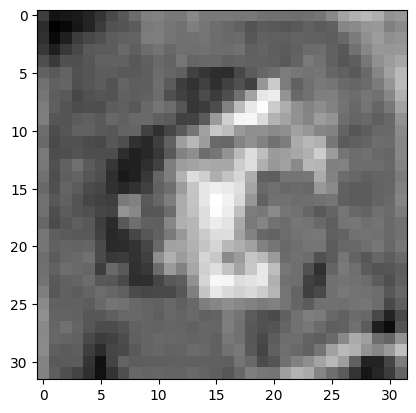

In [4]:
plt.imshow(x_4[0][3].cpu(), cmap="gray")

In [5]:
model = Quat()
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=2e-4)
losses = []

In [6]:
x = x_3 if isinstance(model, Real3) else x_4
x_test = x_test_3 if isinstance(model, Real3) else x_test_4

In [13]:
x.shape

torch.Size([50000, 4, 32, 32])

In [11]:
for epoch in tqdm(range(10)):
    batch_size = 2**13
    for i in range(0, len(x), batch_size):
        batch_x, batch_y = x[i:i+batch_size], y[i:i+batch_size].float()
        optimiser.zero_grad()
        output = model(batch_x)
        loss = F.mse_loss(output, batch_y)
        loss.backward()
        optimiser.step()
    losses.append(loss.item())

100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


Train accuracy: 48.83%
Test accuracy: 49.49%


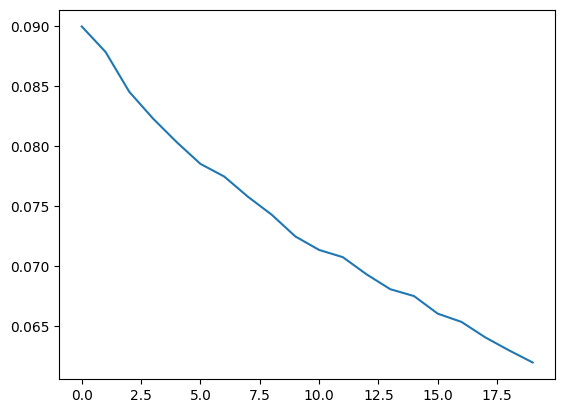

In [12]:
y_pred = torch.cat([model(c).detach().cpu() for c in torch.chunk(x, 10)])
y_pred_test = model(x_test).detach().cpu()

train_accuracy = accuracy_score(y.argmax(1).cpu(), y_pred.argmax(1))
test_accuracy = accuracy_score(y_test.argmax(1).cpu(), y_pred_test.argmax(1))

print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")
plt.plot(range(len(losses)), losses)